# Reinforcement learning with policy gradients in pure Python

[This post is also available as a Jupyter notebook.](https://github.com/jklaise/personal_website/tree/master/notebooks/rl_policy_gradients.ipynb)

It appears to be a right of passage for ML bloggers covering reinforcement learning to show how to implement the simplest algorithms from scratch without relying on any fancy frameworks. There is Karpathy's now famous [Pong from Pixels](https://karpathy.github.io/2016/05/31/rl/), and a simple Google search of *"policy gradient from scratch"* will yield a number of blog posts of implementations with varying levels of detail.

I am a firm believer that coming across an algorithm that you will use again and again it is wise to implement the basic version that will work on some simple problem yourself before going on to use some battle-tested open source implementations that people actually use in practice. There is immense utility in actually writing down the maths and implementing the base algorithm for understanding how and why it works which cannot be gained by (skim)-reading some derivations and then turning to an existing implementation with all the bells and whistles.

# Policy gradients

Policy gradients is a family of algorithms for solving reinforcement learning problems by directly optimizing the policy in policy space. This is in stark contrast to value based approaches (such as Q-learning used in [Learning Atari games by DeepMind](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning). Policy gradients have several appealing properties, for one they produce stochastic policies (by learning a probability distribution over actions given observations) whereas value based approaches are deterministic as they will typically choose actions greedily with respect to the value function being learned which can lead to under-exploration (one needs to introduce exploration strategies such as $\epsilon$-greedy explicitly to get around this). Another advantage of policy gradients is their ability to tackle continuous action spaces without discretisation which is necessary for value based methods. This is not to say that value based approaches are useless, one of the biggest disadvantages of policy gradients is their high variance estimates of the gradient updates. This leads to very noisy gradient estimates and can de-stabilize the learning process. I think it is fair to say that a lot of reinforcement learning research with policy gradients in the past few years has been about trying to reduce the variance of these gradient updates to improve the trainability of these algorithms. It is also worth mentioning that in state-of-the-art implementations and tasks it is common to use the so called actor-critic algorithms which includes a policy gradient and a value function estimator to combine the best properties of both approaches.

This blog post is intended as documenting my learning process of deriving and implementing Vanilla Policy Gradient (VPG aka REINFORCE) in pure Python and some of the hurdles and interesting tangents I came across during the process that are less often talked about.

# Deriving the policy gradient update

The derivation of the policy gradient update is standard and can be found online in various levels of detail ([Karpathy](https://karpathy.github.io/2016/05/31/rl/),  [Takeshi](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/), [OpenAI](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#deriving-the-simplest-policy-gradient), [Abbeel](https://drive.google.com/file/d/0BxXI_RttTZAhY216RTMtanBpUnc/view)), and is included here for completeness. In my presentation I have drawn heavily from these sources.

Let $\tau=(s_0,a_0,\dots,s_{T-1},a_{T-1}, s_T)$ be a state-action sequence in a complete trajectory consisting of $T$ steps (note, the final state $s_T$ is a terminal state which results from taking the final action $a_{T-1}$, after which the environment is reset). Define $R(s_t,a_t)$ to be the reward received after observing the state $s_t$ and performing an action $a_t$. Also define the (discounted)[^1] sum of these rewards to be $R(\tau) := \sum_{t=0}^{T-1}\gamma^t R(s_t,a_t)$. Then our goal is to maximize the expected reward

$$
\max_\theta\mathbb{E}_{\pi_\theta}R(\tau),
$$

where $\pi_\theta$ is a parametrized policy (typically a neural network). The expected value is taken with respect to drawing trajectories $\tau$ under the policy $\pi_\theta$ and so solving this problem is equivalent to finding the "best" parameters $\theta$ that give the best policy for maximizing the expected reward.

We can do this via the usual gradient ascent, i.e. suppose we know how to calculate the gradient with respect to the parameters, $\nabla_\theta\mathbb{E}_{\pi_\theta}R(\tau)$, then we can update the parameters $\theta$ in the direction of the gradient:

$$
\theta\leftarrow\theta+\alpha\nabla_\theta\mathbb{E}_{\pi_\theta}R(\tau), 
$$

where $\alpha$ is the usual learning rate hyperparameter.

Let $P(\tau\vert\theta)$ be the probability of a trajectory $\tau$ under the policy $\pi_\theta$. Then we can write the gradient as follows:

$$
\begin{aligned}
\nabla_\theta\mathbb{E}_{\pi_\theta}R(\tau) &= \\
&= \nabla_\theta\sum_\tau P(\tau\vert\theta)R(\tau) & \text{ definition of expectation}  \\
&= \sum_{\tau}\nabla_\theta P(\tau\vert\theta)R(\tau) & \text{ swap sum/integral and gradient} \\
&= \sum_{\tau}\frac{P(\tau\vert\theta)}{P(\tau\vert\theta)}\nabla_\theta P(\tau\vert\theta)R(\tau) & \text{ multiply and divide by $P(\tau\vert\theta)$} \\
&= \sum_{\tau}P(\tau\vert\theta)\nabla_\theta\log P(\tau\vert\theta)R(\tau) & \text{ recognize that $\nabla_x\log(f(x))=\frac{\nabla_x f(x)}{f(x)}$}\\
&= \mathbb{E}_{\pi_\theta}\left(\nabla_\theta\log P(\tau\vert\theta)R(\tau)\right) & \text{ definition of expectation}
\end{aligned}
$$

Now we can expand the probability of a trajectory $\tau$ as follows:

$$
P(\tau\vert\theta)=p(s_0)\prod_{t=0}^{T-1}p(s_{t+1}\vert s_t,a_t)\pi_\theta(a_t\vert s_t),
$$

where $p(s_{t+1}\vert s_t,a_t)$ is the probability of transitioning to state $s_{t+1}$ by taking an action $a_t$ in state $s_t$ (as specified by the Markov Decision Process underlying the RL problem) and $p(s_0)$ is the starting state distribution. Taking the gradient of the log-probability (abbreviated as grad-log-prob from here on) of a trajectory thus gives

$$
\begin{aligned}\label{eq:pg}
\nabla_\theta\log P(\tau\vert\theta) &= \\
&= \nabla_\theta\left(\log p(s_0)+\sum_{t=0}^{T-1}\left(\log p(s_{t+1}\vert s_t,a_t)+\log\pi_\theta(a_t\vert s_t)\right)\right) \\
&= \sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\vert s_t).
\end{aligned}
$$
Note that after taking the gradient, the dynamics model $p(s_{t+1}\vert s_t,a_t)$ disappears, i.e. policy gradients are a *model-free* method.

Putting this all together we arrive at the policy gradient expression:

$$
\nabla_\theta\mathbb{E}_{\pi_\theta} R(\tau) = \mathbb{E}_{\pi_\theta}\left(\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\vert s_t)R(\tau)\right),
$$
and because it is an expectation it can be estimated by Monte Carlo sampling of trajectories:

$$
\nabla_\theta\mathbb{E}_{\pi_\theta} R(\tau)\approx\frac{1}{L}\sum_{\tau}\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\vert s_t)R(\tau),
$$
where $L$ is the number of trajectories used for one gradient update.

Equation (4) is the basic expression for a policy gradient update relating the observed rewards to the probabilities of the policy used to obtain them. However, if you look at it and think about the role of the rewards of the whole trajectory $R(\tau)$ you notice something strange - it features as a multiplier for every grad-log-prob term in the sum over the episode, i.e. the reward obtained *over the whole episode* is used to change the probabilities of each action taken during the episode. This is saying that even rewards obtained before taking a certain action affect that action via the gradient update. This is not desirable as ideally we want to attribute to an action only those (and future) rewards that were received after taking that action.

With some algebra and rearrangement (For an in-depth derivation I recommend [this](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/) blog post. [OpenAI](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you) also has a great write-up about this, including a [proof](https://spinningup.openai.com/en/latest/spinningup/extra_pg_proof1.html).) we can re-write the policy gradient as follows:

$$
\nabla_\theta\mathbb{E}_{\pi_\theta}R(\tau) = \mathbb{E}_{\pi_\theta}\left(\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\vert s_t)\sum_{t^\prime=t}^{T-1}\gamma^{t^\prime-t}R(s_{t^\prime},a_{t^\prime})\right),
$$
so that actions are reinforced only by rewards following after taking them (I call this form temporally-adjusted rewards). I have outlined a bit more how this helps during training and how it fits into the more general reward formulation and variance reduction framework in [A. Alternative reward formulations and variance reduction](#appendix-a).

[^1]: Why discount? The main reason is to accommodate theoretical convergence of the reward sequence for infinite-horizon episodes. Practically a discount factor $\gamma<1$ can improve convergence and reduce variance in the policy gradient updates. For simple problems with short trajectories it is often unneeded. Additionally it can be thought of the same as the discount factor in finance - the same amount of money tomorrow is worth slightly less than today due to forgoing potential interest on money if it was received today.

# Implementation

We will use the theory to solve a classic (and a very simple) RL problem - the Cartpole problem. In the Cartpole problem the task is to balance an upright pole resting on a trolley by pushing the trolley left and right. The observation at each states is a vector of length 4 (describing physical properties of the pole, [position of cart, velocity of cart, angle of pole, rotation rate of pole](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L21)) [^2] and the possible set of actions at each step is binary - move the cart left or right. The reward function for this particular problem is also very simple: +1 for every step in which the pole is kept upright. An episode finishes either when a reward of +200 is received (the problem is defined to be solved if we can balance the pole for so long) or when the pole tilts enough to lose balance.

[^2]: Note that in model-free reinforcement learning the meaning of the parameters is not important, in fact, it is the main appeal of model-free RL methods that they can learn to solve problems without explicit prior knowledge about the environment.

We will use OpenAI's [gym](https://github.com/openai/gym) package which includes the Cartpole environment amongst many others (e.g. Atari games and MuJoCo simulation engine). Let's import the module, set up the environment and check the observation and action space:

In [1]:
import gym
env = gym.make('CartPole-v0')

In [2]:
env.observation_space

Box(4,)

In [3]:
env.action_space

Discrete(2)

Now that we know that the dimensions of the observation and action space we can design a policy that takes in observations and produces probabilities of actions. Typically the parametrized policy $\pi_\theta$ is a neural network where $\theta$ represents the learnable weights of the network. In our case the problem is so simple that there is no need for a sophisticated neural network policy. We will instead use plain logistic regression to parametrize probabilities of moving left and right. Additionally, we will use this simple form of a policy to manually derive the gradients for the policy gradient update rule.

Let $x$ denote the length 4 observation vector. Because the cartpole problem is fully observable[^3], the observation and the state are interchangeable concepts. Let $\pi_\theta(0\vert x)=\dfrac{1}{1+e^{-\theta\cdot x}}=\dfrac{e^{\theta\cdot x}}{1+e^{\theta\cdot x}}$ be the probability of action $0$ (move cart to the left), then $\pi_\theta(1\vert x)=1-\pi_\theta(0\vert x)=\dfrac{1}{1+e^{\theta\cdot x}}$. Thus our policy is parametrized by a vector $\theta$ of length four.

To apply the policy gradient update we need to derive $\nabla_\theta\log\pi_\theta(a\vert x)$:

$$
\begin{aligned}
\nabla_\theta\log\pi_\theta(0\vert x) &= \\
&= \nabla_\theta\left(\theta\cdot x-\log(1+e^{\theta\cdot x})\right) \\
&= x - \frac{xe^{\theta\cdot x}}{1+e^{\theta\cdot x}} \\
&= x - x\pi_\theta(0\vert x)
\end{aligned}
$$

and

$$
\begin{aligned}
\nabla_\theta\log\pi_\theta(1\vert x) &= \\
&= \nabla_\theta\left(-\log(1+e^{\theta\cdot x})\right) \\
&= -\frac{xe^{\theta\cdot x}}{1+e^{\theta\cdot x}} \\
&= -x\pi_\theta(0\vert x).
\end{aligned}
$$

Of course when $\pi_\theta$ is a neural network you would rely on the auto-differentiation capabilities of your deep learning framework to do these calculations for you.

**Observation:** I came across a lot of different implementations of policy gradients on binary action space problems, some were using the Logistic Policy while others used [Softmax](https://en.wikipedia.org/wiki/Softmax_function). It turns out that Softmax applied to  a binary action space is not exactly equivalent to a Logistic policy - it has more parameters (8 for Softmax and 4 for Logistic in the cartpole example). I have outlined why this happens in [B. Overparametrisation of Softmax](#appendix-b).

Let's write this up into a Python class that will act as our Logistic policy agent. The class will have all the methods required for calculating action probabilities and acting based on those, calculating grad-log-prob gradients and temporally adjusted discounted rewards and updating the policy parameters after the end of an episode (we will update the parameters after every episode, but for more difficult problems a gradient update is typically performed after a batch of episodes to make training more stable):

[^3]: In a real, physical environment the state of the cartpole problem would be much more complicated - it would include things like temperature, wind, friction between joints etc. In principle all of these could be measured and included in the observation vector, but it would be impossible to extract all the information about the state into an observation vector. In problems with partial observability (e.g. multiplayer games with imperfect information) the observations available to any one player are naturally a limited representation of the game state.

In [4]:
import numpy as np

class LogisticPolicy:
    
    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ
        
        self.θ = θ
        self.α = α
        self.γ = γ
        
    def logistic(self, y):
        # definition of logistic function
        
        return 1/(1 + np.exp(-y))
    
    def probs(self, x):
        # returns probabilities of two actions
        
        y = x @ self.θ
        prob0 = self.logistic(y)
        
        return np.array([prob0, 1-prob0])        
    
    def act(self, x):
        # sample an action in proportion to probabilities
        
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        
        return action, probs[action]
    
    def grad_log_p(self, x):
        # calculate grad-log-probs
        
        y = x @ self.θ        
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)
        
        return grad_log_p0, grad_log_p1
        
    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode
        
        return grad_log_p.T @ discounted_rewards
    
    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards
        
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards
            
        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])
        
        assert grad_log_p.shape == (len(obs), 4)
        
        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)
        
        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)
        
        # gradient ascent on parameters
        self.θ += self.α*dot

**Tangent:** during the writing of the temporally-adjusted discounted_rewards function I started thinking if one can optimize the for loop for better performance. For my attempts see [C. Efficient calculation of temporally adjusted discounted rewards](#appendix-c).

Let's also write a utility function that will run through one full episode and record all observations, actions taken and rewards received.

In [5]:
def run_episode(env, policy, render=False):
    
    observation = env.reset()
    totalreward = 0
    
    observations = []
    actions = []
    rewards = []
    probs = []
    
    done = False
    
    while not done:
        if render:
            env.render()
        
        observations.append(observation)
        
        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)
    
    return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

Finally, we write a training loop that will train an agent on the problem by repeated rollouts of a policy that is updated after the end of every episode:

In [11]:
def train(θ, α, γ, Policy, MAX_EPISODES=10000, seed=None, evaluate=False):
    
    # initialize environment and policy
    env = gym.make('CartPole-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)
    
    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):
        #env.render()
        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)
                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        
        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = Monitor(env, 'pg_cartpole/', video_callable=False, force=True)
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()
        
    return episode_rewards, policy

Let's run it:

In [12]:
# additional imports for saving and loading a trained policy
from gym.wrappers.monitor import Monitor, load_results

# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED,
                                evaluate=True)

Let's inspect the results by plotting the reward against episode number during training:

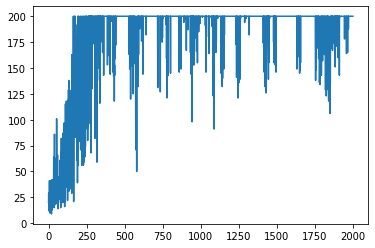

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);

We can see from this plot that our agent does learn to control the cart! It looks like it is starting to be able to balance the pole for 200 steps after ~500 episodes. Note, however, that the reward plot exhibits the typical high-variance of policy gradient methods, even after 1000+ episodes the learned policy can be unstable and lead to sub-par performance. This could be mitigated by employing some simple variance reduction techniques (the first thing to try would be increase the number of episodes per gradient update) and also employing learning rate scheduling so that when we learn a good policy we don't deviate too much from it[^4]. Also, it would be helpful and is indeed necessary to run the training multiple times with different random seeds to get an estimate of mean performance over time (with standard errors), this would be essential to compare the performance of different algorithms against each other.

[^4]: In practice the [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347) is used which prohibits policy updates that are too large.

There is a joke that reinforcement learning is the only area of machine learning where it's acceptable to test on the training set which is kind of what we've done by looking at the performance during training (in practice this is not a problem as the environment does not change between training and evaluation unless you are specifically studying robustness of RL methods which require good performance at test time on environments unseen at training time). Additionally, we can load the last saved policy from disk and look at it's performance on the environment:

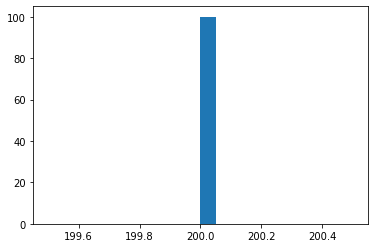

In [9]:
results = load_results('pg_cartpole')
plt.hist(results['episode_rewards'], bins=20);

This is saying that the last trained policy was able to successfully control the cart and keep the pole upright for 200 steps in all 100 evaluation episodes!

# Further reading

[OpenAI educational resource on RL](https://spinningup.openai.com/en/latest/index.html)

Lilian Weng's [A (Long) Peek into RL](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html) and [Policy Gradient Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)

[Daniel Takeshi's derivations of policy gradients](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/)

[Sutton et. al. Policy Gradients in NIPS 1998](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)

# A. Alternative reward formulations and variance reduction <a class="anchor" id="appendix-a"></a>

When I was first implementing policy gradients, I used the basic form of the policy gradient with $R(\tau)$ multiplying every grad-log-prob term in an episode and could not get the policy to converge. Even though both the $R(\tau)$ and temporally-adjusted formulations of the policy gradient have the same expected value, the variance is different. Unsurprisingly, using the first version gives high-variance gradient updates which in some cases may be severe enough to prevent converging to the optimal policy within the allotted time.

Re-writing the policy gradient expression to take into account only rewards obtained after taking an action is a *variance reduction* technique and a lot of the progress on policy gradient methods has been centered around finding equivalent (in expected value) gradient update rules with reduced variance thus making the training more stable and likely to converge to the optimal policy.

I like to group variance reduction techniques in two groups, simple and less-simple. The simple ones include:
 - Temporal reward structure (as discussed here)
 - Increasing number of episodes per gradient update
 - Introducing the discount factor $\gamma$
 - Reward normalization (subtract mean, divide by standard deviation)
 
The more complex ones are:
 - Introducing a baseline (multiple choices, but often leads to the action-value or advantage function and actor-critic methods)
 - Generalized advantage estimation (GAE) - this introduces a set of hyper-parameters to introduce some bias in the policy gradient update to control variance even further ([see the paper](https://arxiv.org/abs/1506.02438)). I recommend [this blog post](https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/) for a write-up.
 - [TRPO](https://arxiv.org/abs/1502.05477) and [PPO](https://arxiv.org/abs/1707.06347) modifications to Vanilla Policy Gradient which prevent the policy changing too rapidly

The GAE paper includes a neat summary of the most common policy gradient expressions used in practice:

![](gae_paper_pg_basics.png)

There is a lot going on, even with the simple methods and there are few ablation studies out there that empirically test which methods contribute most to the variance reduction.

# B. Overparametrisation of Softmax <a class="anchor" id="appendix-b"></a>

In logistic regression we use the parametrized logistic function $f_\theta(x)=\dfrac{e^{\theta\cdot x}}{1+e^{\theta\cdot x}}$ where $\theta, x$ are the $k$-dimensional weight and feature vectors respectively (we assume the bias term is incorporated within $\theta$ and $x$). Because there are only two classes, we interpret the value of $f_\theta(x)$ as $p(y=1\vert \theta,x)$, i.e. the probability of the first class. Then we get the probability of the second class for free since probabilities must sum to one.

The parametrized softmax function defined as $\sigma_\theta(x)_i=\dfrac{e^{\theta_i\cdot x}}{\sum_{j=1}^{m}e^{\theta_j\cdot x}}$ for $i=1,\dots,m$ is a generalization of the logistic function to $m$ output classes and extends logistic regression to multi-class problems. We interpret the value of $\sigma_\theta(x)_i$ as $p(y=i\vert \theta_i, x)$ for $i=1,\dots,m$. Note that with softmax there is a separate weight vector $\theta_i$ for each of the classes.

There is a subtle difference in going from the logistic function to the softmax function that is rarely explained but becomes apparent when you compare using the softmax function instead of the logistic function for a two-class problem. Essentially, the logistic function only maintains a parameter vector $\theta$ of length $k$ for estimating the first class probability while the softmax function maintains a separate parameter vector for each of the classes, thus in the two-class case a softmax formulation would have $2k$ parameters - twice as many as in logistic regression. This means that the softmax formulation results in redundant parameters - this is called overparametrization.

Let's write this out in detail. The class probabilities for an m-class problem are given by

$$
p(y=i\vert \theta_i,x) = \dfrac{e^{\theta_i\cdot x}}{\sum_{j=1}^{m}e^{\theta_j\cdot x}} \text{ ,for $i=1,\dots,m$}.  
$$

Let $\phi$ be some fixed vector and note that if we replace all $\theta_i$ by $\theta_i-\phi$, the probabilities are unchanged:

$$
\begin{aligned}
\dfrac{e^{(\theta_i-\phi)\cdot x}}{\sum_{j=1}^{m}e^{(\theta_j-\phi)\cdot x}} &= \\
&= \dfrac{e^{-\phi\cdot x}e^{\theta_i\cdot x}}{e^{-\phi\cdot x}\sum_{j=1}^{m}e^{\theta_j\cdot x}} \\
&= p(y=i\vert \theta_i,x).
\end{aligned}
$$

In particular, we can pick $\phi=\theta_0$ thus setting the first parameter vector to be identically zero in effect eliminating $k$ redundant parameters from calculations. Doing so in the $2$-class problem we would recover ordinary logistic regression with $k$ parameters, i.e. setting $\theta_0\to 0$ and $\theta_1\to\theta_1-\theta_0=:\theta$ would give $p_0=\dfrac{1}{1+e^{\theta\cdot x}}$ and $p_1=\dfrac{e^{\theta\cdot x}}{1+e^{\theta\cdot x}}$ as in vanilla logistic regression.

In our cartpole example because we used a vanilla logistic policy we ended up with four trainable weights, one for each of the observations. However, had we gone for a softmax policy with two classes we would have eight trainable weights instead.

In an $m$-class problem, the number of weights maintained by softmax is $m\times k$ but $k$ of these can be eliminated as shown. In practice, however, it is less hassle to keep the softmax formulation as is since enforcing some parameters to be zero would lead to less clean code and extra difficulties when calculating gradients.

For more discussion on the softmax function look [here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) and for more details concerning the overparametrization of softmax look [here](http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression).

# C. Efficient calculation of temporally adjusted discounted rewards <a class="anchor" id="appendix-c"></a>

Looking at the training code, a potential inefficiency is in the function that calculates the discounted rewards for each step in an episode. Since it is a for loop in Python it is worth investigating whether it can be sped up by vectorizing.

First, let's time the original function with some random vectors of fixed size:

In [10]:
def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for i in reversed(range(0, len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]
        discounted_rewards[i] = cumulative_rewards
    return discounted_rewards

In [11]:
%timeit discount_rewards(np.random.rand(100), 0.99)

78 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## First attempt: vectorizing
The first thing when you see a for loop in numerical Python code is trying to see if you can vectorize it for performance. If we let $\mathbf{r,\hat{r}}$ be the vectors containing the original and discounted rewards respectively for each step in the episode then we can write the above for loop as a matrix equation $\mathbf{\hat{r}}=\mathbf{\Gamma r}$, where

$$
\mathbf{\Gamma} =  \begin{bmatrix}1 & \gamma & \gamma^2 & \cdots & \gamma^{n-1} \\ 
0 & 1 & \gamma & \cdots & \gamma^{n-2} \\
\vdots & & \ddots & \\
0 & 0 & \cdots & 1 & \gamma \\
0 & 0 & 0 & \cdots & 1
\end{bmatrix}.
$$

This type of matrix is known as a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix) (research hack: I did not know the name of this type of matrix but I thought it must have one given its special properties, so I typed in an example matrix into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=%5B%5B1,a,a%5E2%5D,%5B0,1,a%5D,%5B0,0,1%5D%5D) which kindly provided me with a name). Scipy has a function ```scipy.linalg.toeplitz``` for constructing such matrices, so let's try to use it to rewrite our code like this:

In [12]:
import scipy as sp
import scipy.linalg

def toeplitz_discount_rewards(rewards, gamma):
    n = len(rewards)
    c = np.zeros_like(rewards)
    c[0] = 1
    
    r = np.array([gamma**i for i in range(n)])
    matrix = sp.linalg.toeplitz(c, r)
    discounted_rewards = matrix @ rewards
    return discounted_rewards

And time this for comparison with the original:

In [13]:
%timeit toeplitz_discount_rewards(np.random.rand(100), 0.99)

74.8 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So in fact this is much worse than the original implementation. This is not a big surprise since there is a lot of overhead in building the matrix and then doing the matrix-vector calculation, so the single pass over the reward vector in the original loop seems pretty performant.

## Second attempt: OpenAI hack

While reading the source code of OpenAI's excellent RL learning library [spinning up](https://spinningup.openai.com/en/latest/) I came across [this curious implementation of discounted rewards](https://github.com/openai/spinningup/blob/fc75b23d539ad1f511e537df9abf21a7aa329706/spinup/algos/vpg/core.py#L45):

In [13]:
import scipy.signal

def magic_discount_rewards(rewards, gamma):
    return sp.signal.lfilter([1], [1, float(-gamma)], rewards[::-1], axis=0)[::-1]

This is using the Scipy signal processing library, using a digital filter on a 1D data sequence ([see the docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)).

Let's test it:

In [14]:
%timeit magic_discount_rewards(np.random.rand(100), 0.99)

25.9 µs ± 316 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This is two to three times faster than the original implementation! Well worth using for problems where this calculation is frequent.